# Visualize Slides

We develop visualizations for `Slide` sequences.

In [46]:
from typing import List
from functools import reduce
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import umap

import NegativeClassOptimization.config as config
import NegativeClassOptimization.datasets as datasets

In [2]:
df = pd.read_csv(config.DATA_SLACK_1_GLOBAL, sep='\t')
df.head(2)

,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,UID,Antigen
0,1873658_06a,CARPENLLLLLWYFDVW,True,LLLLLWYFDVW,-112.82,137442-BRDSLLUDLS,3VRL_1873658_06a,3VRL
1,7116990_04a,CARGLLLLLWYFDVW,True,LLLLLWYFDVW,-112.82,137442-BRDSLLUDLS,3VRL_7116990_04a,3VRL


Are all the aminoacids used in `Slide`? Yes.

In [3]:
def get_aminoacids_list(df) -> List[str]:
    """An utility to extract all used aminoacids in a df['Slide']."""
    aminoacids = reduce(lambda s1, s2: set(s1).union(set(s2)), df["Slide"].to_list(), set([]))
    aminoacids = list(aminoacids)
    print(f"Amino acids used (N={len(aminoacids)}): {aminoacids}")
    return aminoacids

get_aminoacids_list(df);

Amino acids used (N=20): ['I', 'C', 'L', 'P', 'S', 'F', 'D', 'E', 'H', 'G', 'Q', 'K', 'Y', 'V', 'R', 'A', 'M', 'N', 'T', 'W']


One-hot encoding of `Slide`.

In [4]:
def get_one_hot_aa_encoder(aminoacids: List[str] = config.SLIDE_AMINOACIDS):
    """Get a OneHotEncoder fitted to the aminoacids characters used in the `Slide`s of `700k dataset`.

    Args:
        aminoacids (List[str], optional): default list of amino acids used in `Slide`. Defaults to config.SLIDE_AMINOACIDS.

    Returns:
        OneHotEncoder: fitted, ready to transform sequences.
    """    
    aa_as_array = np.array(aminoacids)
    encoder = OneHotEncoder(sparse=False).fit(aa_as_array.reshape(-1, 1))
    return encoder


def onehot_encode(
    string: str, 
    encoder = get_one_hot_aa_encoder()
    ) -> np.array:
    """Encode a string to onehot numpy array with shape (-1).

    Args:
        string (str)
        encoder (_type_, optional): fitted encoder. Defaults to get_one_hot_aa_encoder().

    Returns:
        np.array
    """    
    string_as_array = np.array(list(string))
    string_as_onehot = encoder.transform(string_as_array.reshape(-1, 1))
    return string_as_onehot.reshape(-1)

In [73]:
df_s = df.sample(n=1000)
df_s.head(2)

,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,UID,Antigen
301856,5454465_02a,CAIRGLGRLFAYW,True,IRGLGRLFAYW,-84.19,141603-LUUDLUDSUS,1H0D_5454465_02a,1H0D
437907,4979509_05a,CARRGYYEVYWYFDVW,True,YYEVYWYFDVW,-96.98,137248-RRDLDUDRDR,1ADQ_4979509_05a,1ADQ


In [74]:
df_s["Slide_onehot"] = df_s["Slide"].apply(lambda s: onehot_encode(s))
slide_onehot_array = np.stack(df_s["Slide_onehot"], axis=0)

scaled_slide_onehot_array = StandardScaler().fit_transform(slide_onehot_array)
scaled_slide_onehot_array

array([[-0.30869119, -0.4412971 , -0.12751534, ..., -0.24356115,
         1.0944415 , -0.49374193],
       [-0.30869119, -0.4412971 , -0.12751534, ..., -0.24356115,
         1.0944415 , -0.49374193],
       [-0.30869119,  2.26604707, -0.12751534, ..., -0.24356115,
         1.0944415 , -0.49374193],
       ...,
       [-0.30869119, -0.4412971 , -0.12751534, ..., -0.24356115,
        -0.91370804, -0.49374193],
       [-0.30869119, -0.4412971 , -0.12751534, ..., -0.24356115,
        -0.91370804,  2.02534955],
       [-0.30869119, -0.4412971 , -0.12751534, ..., -0.24356115,
        -0.91370804, -0.49374193]])

4 main umap parameters:
- n_neighbors
- min_dist
- n_components
- metric



In [101]:
reducer = umap.UMAP(n_neighbors=300, min_dist=1e-4, metric="hamming")
embedding = reducer.fit_transform(scaled_slide_onehot_array)
# embedding.shape

df_s["umap_emb_0"] = embedding[:, 0]
df_s["umap_emb_1"] = embedding[:, 1]

/home/eugen/miniconda3/envs/ab-negative-training/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


<AxesSubplot:xlabel='umap_emb_0', ylabel='umap_emb_1'>

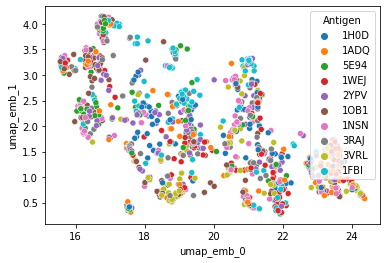

In [102]:
sns.scatterplot(data=df_s, x="umap_emb_0", y="umap_emb_1", hue="Antigen")
# plt.title('UMAP projection of CDR3-Slide')